# Lab 5: Sampling for evaluation

#### We will start by importing numpy, pandas, and matplotlib. (We will import other libraries/packages as we need them.) We will also read our spambase csv file into a pandas dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spambase = pd.read_csv('spambase.csv')

print("Spambase loaded.")

Spambase loaded.


#### Let's build our logistic regression model.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# first we need to prepare the data

# add an intercept column
spambase['_intercept'] = 1

# Copy spambase across and drop spam_class (we don't include the class feature in the training data)
X = spambase
X = X.drop('spam_class', axis=1)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

# now split the data into training data and test data (80/20 split)
# random_state = k sets a specific random seed
# since random_state is fixed, this call will always produce the same split
# if you leave out the random_state value, you will get a different random split when you run it agaimn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# create our model and fit it to our training data
# the large C value essentail turns off regularization (which we will cover later)
# ignore it for now
logres = LogisticRegression(C = 1e9)
logres.fit(X_train,y_train)

# let's check our training and test accuracy
train_score = logres.score(X_train, y_train)
test_score = logres.score(X_test, y_test)

print ("Score on training data:", train_score)
print ("Score on test data:", test_score)

Score on training data: 0.932880434783
Score on test data: 0.909880564604


#### In the cell below, I have provided code that computes and prints the mean of the training and test errors for ten RANDOM train/test splits. Add code to compute and print the corresponding standard deviations.

In [21]:
# compute and print the mean of the training and test errors for ten RANDOM train/test splits

# insert code here
i = 0
total_holdouts = 10
acc = np.zeros((total_holdouts))
tpr = np.zeros((total_holdouts))
fpr = np.zeros((total_holdouts))
while (i < total_holdouts):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

    lr = logres.fit(X_tr, y_tr)
    
    #y_pred = logres.fit(X_tr, y_tr).predict(X_te)
    y_pred = lr.predict(X_te)
    
    # compute confusion matrix
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    j = 0
    while (j < len(y_te)):
        if (y_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1        
        j = j + 1
    acc[i] = (tp+tn)/j
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)
    i = i + 1
        
# include mean and std dev
mean_acc = 0
mean_tpr = 0
mean_fpr = 0
i = 0
while (i < total_holdouts):
    mean_acc = mean_acc + acc[i]
    mean_tpr = mean_tpr + tpr[i]
    mean_fpr = mean_fpr + fpr[i]
    i = i + 1
    
mean_acc = mean_acc/total_holdouts
mean_tpr = mean_tpr/total_holdouts
mean_fpr = mean_fpr/total_holdouts

# ADD CODE TO COMPUTE AND PRINT THE STANDARD DEVIATIONS OF THE THREE STATISTICS
sd_acc = np.std(acc)
sd_tpr = np.std(tpr)
sd_fpr = np.std(fpr)

print("HOLDOUT STATS")
print("Accuracy: mean = ",mean_acc," sd = ",sd_acc)
print("TPR: mean = ",mean_tpr," sd = ",sd_tpr)
print("FPR: mean = ",mean_fpr," sd = ",sd_fpr)


HOLDOUT STATS
Accuracy: mean =  0.92671009772  sd =  0.00616602426254
TPR: mean =  0.893798318499  sd =  0.0176986349807
FPR: mean =  0.0516411570899  sd =  0.0108912799077


#### Bootstrap: In cell below, I have provided code that computes the average performance across b bootstrap samples.

In [4]:
import random

# average performance across b=5 bootstrap samples
total_bootstraps = 5

bootstrap_size = len(y)

i = 0
bootstrap_idx = np.zeros((bootstrap_size+1))
acc = 0
while (i < total_bootstraps):
    # create bootstrap training and set
    j = 0
    while (j < bootstrap_size): 
        bootstrap_idx[j] = random.randint(0,bootstrap_size-1)
        j = j + 1
    bootstrap_idx[j] = j # add value to enable stopping duribng bootstrap creation
    
    bootstrap_idx.sort()
    
    j = 0
    boots_idx = 0
    X_te = pd.DataFrame(columns=X.columns)
    y_te = pd.DataFrame(columns=y_df.columns)
    X_tr = pd.DataFrame(columns=X.columns)
    y_tr = pd.DataFrame(columns=y_df.columns)
    done = False
    while (done==False):
        if (bootstrap_idx[boots_idx] != j):
            df = X[j:j+1]
            X_te = X_te.append(df, ignore_index=True)
            df = y_df[j:j+1]
            y_te = y_te.append(df, ignore_index=True)
        else:
            while (bootstrap_idx[boots_idx] == j):
                df = X[j:j+1]
                X_tr = X_tr.append(df, ignore_index=True)
                df = y_df[j:j+1]
                y_tr = y_tr.append(df, ignore_index=True)
                boots_idx = boots_idx + 1   
        j = j + 1
        if (j==bootstrap_size):
            done = True
        if (boots_idx==bootstrap_size):
            done = True

    print("Fraction of instances in test data = ", len(y_te)/len(y))  
                
    # fit model and make predictions
    y_tr = np.ravel(y_tr)
    y_tr = y_tr.astype('int')
    y_te = np.ravel(y_te)
    y_te = y_te.astype('int')
    lr = logres.fit(X_tr, y_tr)
    
    y_tr_pred = lr.predict(X_tr)
    y_te_pred = lr.predict(X_te)
    
    # compute bootstrap accuracy
    te_acc = 0
    j = 0
    while (j < len(y_te)):
        if (y_te[j] == y_te_pred[j]):
            te_acc = te_acc + 1
        j = j + 1
    
    tr_acc = 0
    j = 0
    while (j < len(y_tr)):
        if (y_tr[j] == y_tr_pred[j]):
            tr_acc = tr_acc + 1
        j = j + 1
    
    te_acc = te_acc/len(y_te)
    tr_acc = tr_acc/len(y_tr)
    acc = acc + (.632*te_acc) + (.368*tr_acc)
    
    i = i + 1  
  
acc = acc/total_bootstraps
print("BOOTSTRAP STATS")
print("Accuracy = ", acc)


Fraction of instances in test data =  0.3729623994783743
Fraction of instances in test data =  0.3707889589219735
Fraction of instances in test data =  0.3677461421430124
Fraction of instances in test data =  0.3727450554227342
Fraction of instances in test data =  0.36926755053249294
BOOTSTRAP STATS
Accuracy =  0.9278315722006563


#### 10-fold cv: In the box below, I have include code to perform and report statistics for 10-fold cv. Review the code and add code to plot a stacked bargraph showing the distribution of class for each fold.

Acc, TPR, FPR =  0.9284938056944143 0.8891340319911748 0.04591104734576758


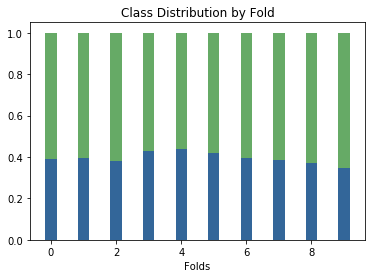

In [37]:
from sklearn.model_selection import KFold

k = 10

X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

X = np.ravel(X_df).reshape(4601, 58)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

kf = KFold(n_splits=k, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

foldPositive = []
foldNegative = []

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    lr = logres.fit(X_tr, y_tr)
    y_te_pred = lr.predict(X_te)

    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1       
        j = j + 1
        
    localPositive = (y_te == 1).sum() / len(y_te) # out of total
    localNegative = (y_te == 0).sum() / len(y_te) # out of total
    
    foldPositive.append(localPositive)
    foldNegative.append(localNegative)
               
acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("Acc, TPR, FPR = ", acc, tpr, fpr)

# Add code for the plotting of stacked bar graph show distribution of classes for each fold
ind = np.arange(k)
width = .35
p1 = plt.bar(ind, foldPositive, width, color='#336699')
p2 = plt.bar(ind, foldNegative, width, bottom=foldPositive, color='#66AA66')


plt.xlabel('Folds')
plt.title('Class Distribution by Fold')

plt.show()

#### Stratified 10-fold cv:  In the box below, write code that performs stratified 10-fold cv and print the final performance statistics (acc, tpr, fpr). Include the code for the stacked bar chart.

Acc, TPR, FPR =  0.9269723973049337 0.8885824600110315 0.04806312769010043


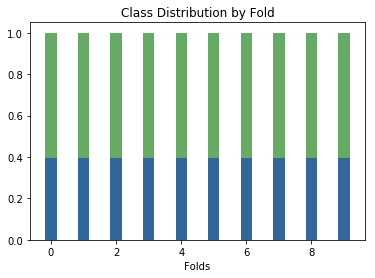

In [38]:
from sklearn.model_selection import StratifiedKFold

k = 10

X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

X = np.ravel(X_df).reshape(4601, 58)

# Set y as the spam column, we need # insert code here

# include stacked bar graphto wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

foldPositive = []
foldNegative = []

for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    lr = logres.fit(X_tr, y_tr)
    y_te_pred = lr.predict(X_te)
 
    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1       
        j = j + 1
        
    localPositive = (y_te == 1).sum() / len(y_te) # out of total
    localNegative = (y_te == 0).sum() / len(y_te) # out of total
    
    foldPositive.append(localPositive)
    foldNegative.append(localNegative)
               
acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("Acc, TPR, FPR = ", acc, tpr, fpr)

# Add code for the plotting of stacked bar graph show distribution of classes for each fold
ind = np.arange(k)
width = .35
p1 = plt.bar(ind, foldPositive, width, color='#336699')
p2 = plt.bar(ind, foldNegative, width, bottom=foldPositive, color='#66AA66')


plt.xlabel('Folds')
plt.title('Class Distribution by Fold')

plt.show()

#### loo cv: In the bow below, write code that performs leave-one-out cv and print the final performance statistics (acc, tpr, fpr).

In [42]:
from sklearn.model_selection import KFold


X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

X = np.ravel(X_df).reshape(4601, 58)

k = 4601

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

kf = KFold(n_splits=k, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

foldPositive = []
foldNegative = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    lr = logres.fit(X_tr, y_tr)
    y_te_pred = lr.predict(X_te)

    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1       
        j = j + 1
        
    localPositive = (y_te == 1).sum() / len(y_te) # out of total
    localNegative = (y_te == 0).sum() / len(y_te) # out of total
    
    foldPositive.append(localPositive)
    foldNegative.append(localNegative)
               
acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("Acc, TPR, FPR = ", acc, tpr, fpr)

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [751]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3330]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2026]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4225]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1693]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3763]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1165]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3454]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2733]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3139]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1952]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [145]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3095]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1052]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1979]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1698]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [903]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2010]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3901]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1221]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1233]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4502]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3219]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3114]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1551]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4513]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3966]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3965]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2216]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2309]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2534]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1179]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2183]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [859]
TRAIN: [   0    1    2 ..., 4598

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3663]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4069]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3718]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3375]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2691]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [641]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [682]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4211]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [771]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4137]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2965]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3550]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4163]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4523]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2029]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1900]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1969]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4084]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3124]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [717]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4280]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [275]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2720]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4148]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2055]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [426]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4210]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1108]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1597]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [575]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1684]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3013]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4491]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [863]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3507]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1636]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [768]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [43]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2328]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3802]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3185]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2271]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3047]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [209]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4309]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3483]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4277]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2571]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4127]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [36]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3440]
TRAIN: [   0    1    2 ..., 4598 4599

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1286]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1743]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [199]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4263]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [921]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [940]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4291]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2069]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2146]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2653]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [722]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [399]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1396]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2145]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4097]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3353]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3835]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1888]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2681]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [974]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [387]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2337]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3273]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1619]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1649]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3898]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3059]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1645]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3431]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4538]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3547]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4246]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2392]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [951]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2374]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [507]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1111]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [782]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2142]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3274]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [265]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [788]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [864]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2879]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3973]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2570]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1639]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3685]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2826]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1970]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3642]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3224]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2515]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1973]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [30]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3675]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3012]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4410]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1170]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4527]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2319]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [186]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1912]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4117]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4105]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1369]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [239]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [325]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [352]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2241]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1056]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4296]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3996]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4015]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1696]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2592]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3182]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1362]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [94]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1699]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1763]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1623]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3204]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4047]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2794]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1391]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [742]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3309]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1838]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [313]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [363]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3995]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3989]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3298]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3017]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [834]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1744]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4432]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4287]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [198]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2347]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3630]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4091]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3271]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2808]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [461]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4092]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3049]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3743]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3099]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3699]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1913]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3322]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4071]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2801]
TRAIN: [   0    1    2 ..., 4597 4598 4599] TEST: [4600]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [531]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4051]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1417]
TRAIN: [   0    1    2 ..., 4598 

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [189]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [678]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3882]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1775]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1008]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [40]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3138]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1851]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3357]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [612]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3044]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4034]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3460]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4108]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [695]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4086]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1860]
TRAIN: [   0    1    2 ..., 4598 4599

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3560]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1768]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1504]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3152]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1383]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [807]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3170]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2662]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1842]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1240]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1004]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2567]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [536]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1728]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3919]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3652]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [441]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3067]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2935]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [196]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1809]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3024]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2449]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1544]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [292]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2429]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1996]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2945]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2667]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3021]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [984]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2154]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [705]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3493]
TRAIN: [   0    1    2 ..., 4598 45

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4238]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3502]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2054]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [366]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2875]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3056]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2165]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [448]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3420]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1707]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4083]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2287]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3725]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4324]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3697]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3816]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4292]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2208]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3964]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1440]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1977]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3073]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1648]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2242]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [966]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2311]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2623]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3828]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1710]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3288]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3678]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2086]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1755]
TRAIN: [   0    1    2 ..., 4598

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3200]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [527]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2726]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4248]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1675]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [260]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3133]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [763]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3305]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2512]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4242]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1140]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4289]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2625]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4227]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2919]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4281]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1794]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4346]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [54]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [848]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4104]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1247]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [67]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3079]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2413]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3323]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3674]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1296]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2317]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4337]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1197]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [747]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3361]
TRAIN: [   0    1    2 ..., 4598 4599

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1490]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4304]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3847]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3137]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1375]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [817]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2030]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3530]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3485]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2947]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3145]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1082]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1590]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3287]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3393]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1656]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3978]
TRAIN: [   0    1    2 ..., 4598

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2136]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4180]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2238]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3410]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2940]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1856]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [268]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1708]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2844]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3481]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [92]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4588]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3829]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1183]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [528]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [458]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2527]
TRAIN: [   0    1    2 ..., 4598 459

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4141]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3863]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3526]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4133]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2001]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1804]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3715]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2547]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2018]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [595]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3543]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4570]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4143]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3359]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2823]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1756]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1573]
TRAIN: [   0    1    2 ..., 4598

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4459]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3402]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2158]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3972]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2827]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4557]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2819]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3866]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1449]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3142]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [633]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3926]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3951]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3246]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1402]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [144]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [386]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [764]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [355]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3432]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [180]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2135]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [137]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3582]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3928]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [711]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [877]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1864]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [376]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4003]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4122]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2760]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [219]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [851]
TRAIN: [   0    1    2 ..., 4598 4599 46

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [361]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2500]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1702]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2566]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1861]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [372]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1290]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2480]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4214]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2627]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1430]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3738]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3164]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1474]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4062]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1776]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1749]
TRAIN: [   0    1    2 ..., 4598 

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2986]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4339]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [777]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3786]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3083]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2617]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2084]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2256]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3415]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3636]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2083]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1858]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [632]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2233]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4203]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [975]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4504]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3669]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [793]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1214]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1303]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1142]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3981]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3154]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4587]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1405]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1991]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3377]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [684]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2696]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4204]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1662]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3492]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2110]
TRAIN: [   0    1    2 ..., 4598 

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4388]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3344]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [442]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3980]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2021]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2107]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2191]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [422]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1098]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1317]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2587]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1790]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1123]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [823]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2251]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3358]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4219]
TRAIN: [   0    1    2 ..., 4598 4

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [17]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [274]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [519]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3784]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3627]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2036]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [107]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [826]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1075]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [178]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2009]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [908]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [799]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4348]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4506]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1328]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4345]
TRAIN: [   0    1    2 ..., 4598 4599 46

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [797]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3111]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3250]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2896]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3650]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [320]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [38]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [455]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2820]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3821]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3069]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1748]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [222]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1643]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1902]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [321]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3282]
TRAIN: [   0    1    2 ..., 4598 4599 

TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [4298]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3594]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [242]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3542]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [50]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [192]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2447]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1791]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3231]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2602]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2635]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [110]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2981]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3568]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [1070]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [2755]
TRAIN: [   0    1    2 ..., 4598 4599 4600] TEST: [3958]
TRAIN: [   0    1    2 ..., 4598 459